#**Практическое задание №1**

Установка необходимых пакетов:

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Монтирование Вашего Google Drive к текущему окружению:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [ ]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [ ]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown


#LBL1 - дополнительные библиотеки
from torchvision.models import resnet50, ResNet
import torch, torchvision
from typing import Tuple, Dict

from torch.utils.tensorboard import SummaryWriter

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [22]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        #LBL2 - изменена загрузка датасета. Файлы должны быть в корне диска
        url = f'https://drive.google.com/uc?id={DATASETS_LINKS[name]}'
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'/content/drive/MyDrive/{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        
        self.transform = torchvision.transforms.Normalize(0, 1)

        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

    def __len__(self):
        return len(self.labels)

    def __getitem__(
        self,
        idx: int,
    ) -> Tuple[torch.FloatTensor, int]:
        #LBL3 - реализация getitem.
        img = torch.Tensor(self.images[idx]).view(3, 224, 224)
        img = self.transform(img)
        return torch.FloatTensor(img), self.labels[idx]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:03<00:00, 33.9MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 1.
Label code corresponds to BACK class.


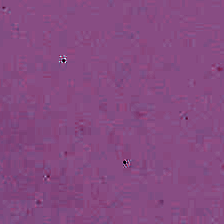

In [23]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [ ]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        # print(type(gt), type(pred))
        # print( tuple(zip(gt, pred))[1] )
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [24]:
#LBL4 - реализация метрик для подсчета по эпохам и вывода в тензорборд.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def compute_metrics(
    outputs: torch.Tensor,
    labels: torch.LongTensor,
) -> Dict[str, float]:

    metrics = {}

    _, pred = torch.max(outputs.data, 1)
    y_true = labels.cpu()
    y_pred = pred.cpu()

    # precision
    precision_micro = precision_score(
        y_true=y_true,
        y_pred=y_pred,
        average="micro",
        zero_division=0,
    )
    precision_macro = precision_score(
        y_true=y_true,
        y_pred=y_pred,
        average="macro",
        zero_division=0,
    )
    precision_weighted = precision_score(
        y_true=y_true,
        y_pred=y_pred,
        average="weighted",
        zero_division=0,
    )


    # f1
    f1_micro = f1_score(
        y_true=y_true,
        y_pred=y_pred,
        average="micro",
        zero_division=0,
    )
    f1_macro = f1_score(
        y_true=y_true,
        y_pred=y_pred,
        average="macro",
        zero_division=0,
    )
    f1_weighted = f1_score(
        y_true=y_true,
        y_pred=y_pred,
        average="weighted",
        zero_division=0,
    )


    metrics["precision_micro"]    = precision_micro
    metrics["precision_macro"]    = precision_macro
    metrics["precision_weighted"] = precision_weighted

    metrics["f1_micro"]    = f1_micro
    metrics["f1_macro"]    = f1_macro
    metrics["f1_weighted"] = f1_weighted

    return metrics

In [25]:
#LBL5 - реализация эпохи обучения
from collections import defaultdict

def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    epoch: int,
) -> None:
    """
    One training cycle (loop).
    """

    model.train()

    epoch_loss = []
    batch_metrics_list = defaultdict(list)

    for i, (images, labels) in tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc="loop over train batches",
    ):

        images, labels = images.to(device), labels.to(device)

        # Подсчет лосса и шаг оптимизатора
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        writer.add_scalar(
            "batch loss / train", loss.item(), epoch * len(dataloader) + i
        )

        with torch.no_grad():
            model.eval()
            outputs_inference = model(images)
            model.train()

        batch_metrics = compute_metrics(
            outputs=outputs_inference,
            labels=labels,
        )

        for metric_name, metric_value in batch_metrics.items():
            batch_metrics_list[metric_name].append(metric_value)
            writer.add_scalar(
                f"batch {metric_name} / train",
                metric_value,
                epoch * len(dataloader) + i,
            )

    avg_loss = np.mean(epoch_loss)
    print(f"Train loss: {avg_loss}\n")
    writer.add_scalar("loss / train", avg_loss, epoch)

    for metric_name, metric_value_list in batch_metrics_list.items():
        metric_value = np.mean(metric_value_list)
        print(f"Train {metric_name}: {metric_value}\n")
        writer.add_scalar(f"{metric_name} / train", metric_value, epoch)

In [26]:
#LBL6 - реализация эпохи валидации на тестовом датасете.
def evaluate_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    epoch: int,
) -> None:
    """
    One evaluation cycle (loop).
    """

    model.eval()

    epoch_loss = []
    batch_metrics_list = defaultdict(list)

    with torch.no_grad():

        for i, (tokens, labels) in tqdm(
            enumerate(dataloader),
            total=len(dataloader),
            desc="loop over test batches",
        ):

            tokens, labels = tokens.to(device), labels.to(device)

            # Подсчет лосса
            
            outputs = model(tokens)
            loss = criterion(outputs, labels)

            epoch_loss.append(loss.item())
            writer.add_scalar(
                "batch loss / test", loss.item(), epoch * len(dataloader) + i
            )

            batch_metrics = compute_metrics(
                outputs=outputs,
                labels=labels,
            )

            for metric_name, metric_value in batch_metrics.items():
                batch_metrics_list[metric_name].append(metric_value)
                writer.add_scalar(
                    f"batch {metric_name} / test",
                    metric_value,
                    epoch * len(dataloader) + i,
                )

        avg_loss = np.mean(epoch_loss)
        print(f"Test loss:  {avg_loss}\n")
        writer.add_scalar("loss / test", avg_loss, epoch)

        for metric_name, metric_value_list in batch_metrics_list.items():
            metric_value = np.mean(metric_value_list)
            print(f"Test {metric_name}: {metric_value}\n")
            writer.add_scalar(f"{metric_name} / test", np.mean(metric_value), epoch)

In [27]:
class Model:

    def __init__(self):
        # todo
        super().__init__()

        self.features = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.features.fc = torch.nn.Linear(512, 9)
        
        # print(self.features)
        self.features.eval()


    def save(self, name: str):
        # todo
        # pass
        # example demonstrating saving the model to PROJECT_DIR folder on gdrive with name 'name'

        torch.save(self.features.state_dict(), f'/content/drive/MyDrive/{name}.pth')

        # arr = np.array([1, 2, 3, 4, 5], dtype=np.float32)
        # np.savez(f'/content/drive/MyDrive/{name}.npz', data=arr)

    def load(self, name: str):
        # todo
        pass
        # example demonstrating loading the model with name 'name' from gdrive using link
        name_to_id_dict = {
            'best': '1-491lAqNlqD-_Fk5XMyXVLHb7KdzIxbQ'
        }
        # https://drive.google.com/file/d/1-491lAqNlqD-_Fk5XMyXVLHb7KdzIxbQ/view?usp=share_link
        #LBL7 - загрузка весов модели. Веса должны быть в корне диска.
        output = name
        # output = f'/content/drive/MyDrive/{name}.pth'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)

        self.features.load_state_dict(torch.load(output))
        print(self.features)


    #LBL8 - реализация обучения модели с сохранением промежуточных весов в 
    # median_weights
    def train(self,
    n_epochs: int,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    ) -> None:
            
        optimizer = torch.optim.Adam(self.features.parameters())

        for epoch in range(n_epochs):

            print(f"Epoch [{epoch+1} / {n_epochs}]\n")

            train_epoch(
                model=self.features,
                dataloader=train_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                writer=writer,
                device=device,
                epoch=epoch,
            )
            evaluate_epoch(
                model=self.features,
                dataloader=test_dataloader,
                criterion=criterion,
                writer=writer,
                device=device,
                epoch=epoch,
            )
            
            self.save('median_weights')
                
        print(f'training done')


    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        # todo: replace this code
        img = torch.FloatTensor(img).cuda()
        transform = torchvision.transforms.Normalize(0, 1)

        # print(transform(img).size())
        # a = torch.Tensor([1]).cuda()
        # pred = torch.cat((a, transform(img).view(3, 224, 224)), 0).cuda()
        prediction = self.features(transform(img).view(1, 3, 224, 224))
        del img
        torch.cuda.empty_cache()
        return prediction


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [28]:
d_train = Dataset('train')
d_test = Dataset('test')
#LBL9 - создание даталоадера для работы с ResNet18
train_dataloader = torch.utils.data.DataLoader(d_train, batch_size = 64,
                                          shuffle=True, num_workers = 2)

test_dataloader = torch.utils.data.DataLoader(d_test, batch_size = 64,
                                          shuffle=False, num_workers = 2)

Downloading...
From: https://drive.google.com/uc?id=1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:49<00:00, 42.1MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:15<00:00, 34.8MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [ ]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

In [ ]:
#LBL10 - вывод слоев в модели.
from torchsummary import summary

model = Model()
model.features.cuda()
summary(model.features, (3, 224, 224), -1)

In [ ]:
#LBL11 - тензорборд с метриками

%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
device = 'cuda'


criterion = torch.nn.CrossEntropyLoss() #torch.Tensor([1, 1.3, 1, 1, 1, 1, 1, 1, 1]).to(device))
writer = SummaryWriter('logs/model')

model.features.to(device)
if not EVALUATE_ONLY:
    model.train(
    10,
    train_dataloader,
    test_dataloader,
    criterion,
    writer,
    device)
    
    model.save('best')
else:
    # todo: your link goes here
    model.load('best')

Пример тестирования модели на части набора данных:

In [ ]:
# evaluating model on 10% of test dataset
with torch.no_grad():
    model.features.eval()
    pred_1 = model.test_on_dataset(d_test, limit=0.1)


In [ ]:
print(pred_1[1])

In [ ]:
pred_1_test = torch.cat(pred_1, 0)
print(pred_1_test.size())

In [ ]:
_, pred = torch.max(pred_1_test, 1)
# print(pred[1])
Metrics.print_all(d_test.labels[:len(pred_1)].tolist(), pred.tolist(), '10% of test')

In [ ]:
torch.cuda.empty_cache()

Пример тестирования модели на полном наборе данных:

In [ ]:
# evaluating model on full test dataset (may take time)
with torch.no_grad():
    model.features.eval()
    if TEST_ON_LARGE_DATASET:
        pred_2 = model.test_on_dataset(d_test)
        pred_2_test = torch.cat(pred_2, 0)
        _, pred = torch.max(pred_2_test, 1)
        Metrics.print_all(d_test.labels, pred.tolist(), 'test')

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9147:
	 balanced accuracy 0.9147:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [29]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
pred_test = torch.cat(pred, 0)
_, pred = torch.max(pred_test, 1)

Metrics.print_all(d_test_tiny.labels, pred.tolist(), 'test-tiny')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From: https://drive.google.com/uc?id=1-491lAqNlqD-_Fk5XMyXVLHb7KdzIxbQ
To: /content/best
100%|██████████| 44.8M/44.8M [00:00<00:00, 247MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Downloading...
From: https://drive.google.com/uc?id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 16.9MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.8667:
	 balanced accuracy 0.8667:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"